# Potts model
In this tutorial, we will learn a Potts model for a multitple sequence alignment using the pseudo-likelihood method. Then we will plot the coupling terms of the learned model and see how they are related to contacts in the native structure of the protein.

In [16]:
import urllib3
import gzip
import pickle
import numpy as np
import os
import jax.numpy as jnp
import jax
import optax
import gemmi
from gemmi import cif
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## Process multiple sequence alignment
The protein family `PF00041` will be used as an example. More information about this family can be found at [Pfam](https://www.ebi.ac.uk/interpro/entry/pfam/PF00041/). First, we need to download the multiple sequence alignment (MSA) of this family from Pfam. 

In [2]:
pfam_id = "PF00041"

if not os.path.exists(f"./data/{pfam_id}_full.txt"):
    http = urllib3.PoolManager()
    r = http.request(
        "GET",
        f"https://www.ebi.ac.uk/interpro/wwwapi//entry/pfam/{pfam_id}/?annotation=alignment:full&download",
    )
    data = gzip.decompress(r.data)
    data = data.decode()
    with open(f"./data/{pfam_id}_full.txt".format(pfam_id), "w") as file_handle:
        print(data, file=file_handle)

Read the MSA file into a dict.

In [3]:
msa = {}
with open(f"./data/{pfam_id}_full.txt", "r") as file_handle:
    for line in file_handle:
        if line.startswith("#"):
            continue
        if line.startswith("//"):
            break

        line = line.strip().split()
        if len(line) == 0:
            continue

        name = line[0]
        seq = line[1]
        msa[name] = seq.upper()

The original MSA might contain sequences that have too many gaps or positions where too many sequences have gaps.  Before using the MSA to learn a Potts model, we will filter it to remove such sequences and positions. Such filtering is important to ensure that the learned model is not biased by sequences or positions that are not informative. We will use the sequence `TENA_HUMAN/804-891` as the reference sequence in the filtering process.

In [18]:
query_seq_id = "TENA_HUMAN/804-891"

## remove positions where the query sequence has gaps
query_seq = msa[query_seq_id] 
idx = [ s == "-" or s == "." for s in query_seq]
for k in msa.keys():
    msa[k] = [msa[k][i] for i in range(len(msa[k])) if not idx[i]]
query_seq = msa[query_seq_id]

## remove sequences that have more than 20% gaps
len_query_seq = len(query_seq)
seq_id = list(msa.keys())
for k in seq_id:
    if msa[k].count("-") + msa[k].count(".") >= len_query_seq * 0.20:
        msa.pop(k)

In [6]:
aa = "RHKDESTNQCGPAVILMFYW"

aa_index = {}
aa_index["-"] = 0
aa_index["."] = 0
i = 1
for a in aa:
    aa_index[a] = i
    i += 1
with open("./output/aa_index.pkl", "wb") as file_handle:
    pickle.dump(aa_index, file_handle)

seq_msa = []
for k in msa.keys():
    if msa[k].count("X") > 0 or msa[k].count("Z") > 0 or msa[k].count("B") > 0:
        continue
    seq_msa.append([aa_index[s] for s in msa[k]])
seq_msa = np.array(seq_msa, dtype=np.int8)

In [7]:
## remove positions where too many sequences have gaps
pos_idx = []
for i in range(seq_msa.shape[1]):
    if np.sum(seq_msa[:,i] == 0) <= seq_msa.shape[0]*0.2:
        pos_idx.append(i)
with open("./output/seq_pos_idx.pkl", 'wb') as file_handle:
    pickle.dump(pos_idx, file_handle)
    
seq_msa = seq_msa[:, np.array(pos_idx)]
with open("./output/seq_msa.pkl", 'wb') as file_handle:
    pickle.dump(seq_msa, file_handle)

It might also contain sequences that are very similar to each other.

In [8]:
## reweighting sequences
seq_weight = np.zeros(seq_msa.shape)
for j in range(seq_msa.shape[1]):
    aa_type, aa_counts = np.unique(seq_msa[:,j], return_counts = True)
    num_type = len(aa_type)
    aa_dict = {}
    for a in aa_type:
        aa_dict[a] = aa_counts[list(aa_type).index(a)]
    for i in range(seq_msa.shape[0]):
        seq_weight[i,j] = (1.0/num_type) * (1.0/aa_dict[seq_msa[i,j]])
tot_weight = np.sum(seq_weight)
seq_weight = seq_weight.sum(1) / tot_weight 
with open("./output/seq_weight.pkl", 'wb') as file_handle:
    pickle.dump(seq_weight, file_handle)

## Learn the model

In [9]:
L = seq_msa.shape[1]
K = 21

params = {
    "h": jnp.zeros((K, L)),
    "J": jnp.zeros((K, K, L, L)),
}

mask_J = np.ones((K, K, L, L), dtype=bool)
mask_J[:, :, range(L), range(L)] = False
mask_J = jnp.array(mask_J)


def compute_log_pseudo_likelihood_pos(param, i, seq):
    h = param["h"]
    J = param["J"]
    J = jnp.where(mask_J, J, 0.0)
    J = 0.5 * (J + jnp.transpose(J, (0, 1, 3, 2)))

    hi = h[:, i]
    Ji = J[:, seq, i, jnp.arange(L)]

    u = hi + jnp.sum(Ji, axis=1)
    cross_entropy = optax.softmax_cross_entropy_with_integer_labels(
        logits=-u[jnp.newaxis, :], labels=seq[jnp.newaxis, i]
    )

    return -cross_entropy


def compute_log_pseudo_likelihood_seq(param, seq):
    ii = jnp.arange(L)
    pseudo_log_likelihood = jax.vmap(
        compute_log_pseudo_likelihood_pos, in_axes=(None, 0, None)
    )(param, ii, seq)
    return jnp.sum(pseudo_log_likelihood)


def compute_log_pseudo_likelihood_msa(param, seq_msa, seq_weight):
    log_pseudo_likelihood = jax.vmap(
        compute_log_pseudo_likelihood_seq, in_axes=(None, 0)
    )(param, seq_msa)
    log_pseudo_likelihood = jnp.sum(log_pseudo_likelihood * seq_weight)
    return log_pseudo_likelihood


batch_size = 1028
num_batches = seq_msa.shape[0] // batch_size + 1
if seq_msa.shape[0] < batch_size * num_batches:
    seq_msa = jnp.concatenate(
        (
            seq_msa,
            jnp.zeros((batch_size * num_batches - seq_msa.shape[0], L), dtype=jnp.int8),
        )
    )
    seq_weight = jnp.concatenate(
        (
            seq_weight,
            jnp.zeros(
                (batch_size * num_batches - seq_weight.shape[0],), dtype=jnp.int8
            ),
        )
    )

seq_msa_batches = jnp.reshape(seq_msa, (num_batches, batch_size, L))
seq_weight_batches = jnp.reshape(seq_weight, (num_batches, batch_size))

batches = {
    "msa": seq_msa_batches,
    "weight": seq_weight_batches,
}

weight_decay = 0.05


def compute_loss(params):
    _, y = jax.lax.scan(
        jax.checkpoint(
            lambda carry, x: (
                carry,
                compute_log_pseudo_likelihood_msa(params, x["msa"], x["weight"]),
            )
        ),
        None,
        batches,
    )
    loss = -jnp.sum(y)
    loss += weight_decay * jnp.sum(params["J"] ** 2)

    return loss


v, g = jax.value_and_grad(compute_loss)(params)


solver = optax.lbfgs()
opt_state = solver.init(params)
value_and_grad = optax.value_and_grad_from_state(compute_loss)
for _ in range(20):
    value, grad = value_and_grad(params, state=opt_state)
    updates, opt_state = solver.update(
        grad, opt_state, params, value=value, grad=grad, value_fn=compute_loss
    )
    params = optax.apply_updates(params, updates)
    print("Objective function: {:.2E}".format(compute_loss(params)))

with open("./output/params.pkl", "wb") as file_handle:
    pickle.dump(params, file_handle)


Objective function: 2.09E+02
Objective function: 1.91E+02
Objective function: 1.71E+02
Objective function: 1.68E+02
Objective function: 1.66E+02
Objective function: 1.65E+02
Objective function: 1.63E+02
Objective function: 1.63E+02
Objective function: 1.62E+02
Objective function: 1.62E+02
Objective function: 1.61E+02
Objective function: 1.61E+02
Objective function: 1.60E+02
Objective function: 1.60E+02
Objective function: 1.59E+02
Objective function: 1.58E+02
Objective function: 1.57E+02
Objective function: 1.57E+02
Objective function: 1.56E+02
Objective function: 1.56E+02


In [10]:
doc = cif.read("./data/1TEN.cif")
block = doc.sole_block()

seq = list(block.find_loop("_atom_site"))

cif_block = gemmi.cif.read("./data/1TEN.cif")[0]
structure = gemmi.make_structure_from_block(cif_block)

model = structure[0]
chain = model[0]
residues = [res for res in chain if not res.is_water()]


def compute_min_distance(res1, res2):
    """Compute the minimum distance between two residues only considering heavy atoms."""
    min_distance = float("inf")
    for atom1 in res1:
        if atom1.is_hydrogen():
            continue
        for atom2 in res2:
            if atom2.is_hydrogen():
                continue
            distance = atom1.pos.dist(atom2.pos)
            if distance < min_distance:
                min_distance = distance
    return min_distance


distances = np.zeros((len(residues), len(residues)))
for i, res1 in enumerate(residues):
    for j, res2 in enumerate(residues):
        if i != j:
            distances[i, j] = compute_min_distance(res1, res2)

with open("./output/distances_from_structure.pkl", "wb") as f:
    pickle.dump(distances, f)
    

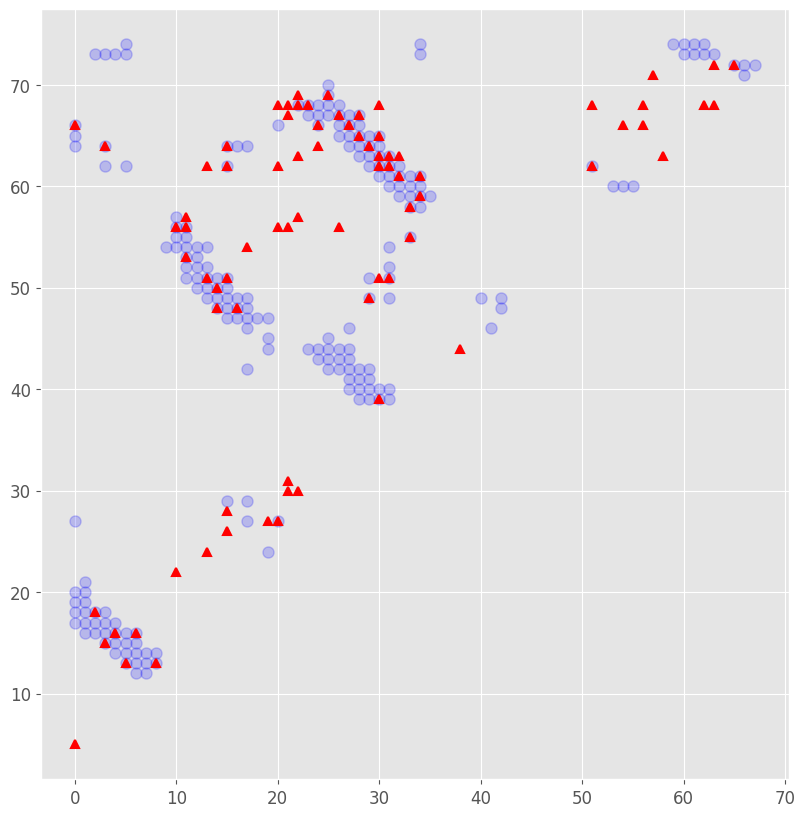

In [17]:
with open("./output/params.pkl", "rb") as f:
    params = pickle.load(f)


J = np.array(params["J"])
L = J.shape[-1]

## calculate interaction scores
Jp = {}
score_FN = np.zeros([L, L])
for i in range(L):
    for j in range(i + 1, L):
        J_prime = J[:, :, i, j]
        J_prime = (
            J_prime
            - J_prime.mean(0).reshape([1, -1])
            - J_prime.mean(1).reshape([-1, 1])
            + J_prime.mean()
        )
        Jp[(i, j)] = J_prime
        score_FN[i, j] = np.sqrt(np.sum(J_prime * J_prime))
        score_FN[j, i] = score_FN[i, j]
score_CN = score_FN - score_FN.mean(1).reshape([-1, 1]).dot(
    score_FN.mean(0).reshape([1, -1])
) / np.mean(score_FN)


for i in range(score_CN.shape[0]):
    for j in range(score_CN.shape[1]):
        if abs(i-j) <= 4:
            score_CN[i,j] = -np.inf
        
tmp = np.copy(score_CN).reshape([-1])
tmp.sort()
cutoff = tmp[-80*2]
contact_plm = score_CN > cutoff
for j in range(contact_plm.shape[0]):
    for i in range(j, contact_plm.shape[1]):
        contact_plm[i,j] = False

with open('./output/distances_from_structure.pkl', 'rb') as f:
    distances = pickle.load(f)

cutoff = 6
contact_pdb = distances < cutoff
for i in range(contact_pdb.shape[0]):
    for j in range(contact_pdb.shape[1]):
        if abs(i-j) <= 4:
            contact_pdb[i,j] = False
        if j <= i:
            contact_pdb[i,j] = False

with open("./output/seq_pos_idx.pkl", "rb") as f:
    seq_pos_idx = np.array(pickle.load(f))

offset = 2
contact_pdb = contact_pdb[seq_pos_idx+offset, :][:, seq_pos_idx+offset]


fig = plt.figure(figsize = (10,10))
fig.clf()
I,J = np.where(contact_pdb)
plt.plot(I,J, 'bo', alpha = 0.2, markersize = 8, label = 'native contacts from PDB')
#plt.imshow(contact_pdb, cmap = "binary", alpha = 0.5)
I, J = np.where(contact_plm)
plt.plot(I,J, 'r^', markersize = 6, mew = 1.5, label = 'predicted contacts from Potts model')
plt.gca().set_aspect('equal', adjustable='box')

# plt.xlim((0,153))
# plt.ylim((0,153))
#plt.title(protein)
#plt.legend()
plt.savefig("./output/contact.png")